In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
from scipy import stats
import matplotlib.font_manager

In [4]:
# import that models that we want to use
from pyod.models.abod import ABOD # Angle-based outlier detection 
from pyod.models.knn import KNN # k nearest neightbor

In [10]:
# create random dataset with outliers
from pyod.utils.data import generate_data, get_outliers_inliers # check documentation 
# https://pyod.readthedocs.io/en/latest/pyod.utils.html#module-pyod.utils.utility

# generate random data with two features 
X_train, y_train = generate_data(n_train = 200, train_only = True, n_features = 2, random_state = 101)
# set random state for repraducability 101

In [11]:
# by default the outlier fraction is 0.1 in generate data function
outlier_fraction = 0.1

# store outliers and inliers in different numpy arrays
x_outliers, x_inliers = get_outliers_inliers(X_train, y_train)

n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

In [12]:
#separate the two features and use it to plot the data 
F1 = X_train[:,[0]].reshape(-1,1)
F2 = X_train[:,[1]].reshape(-1,1)

# create a meshgrid 
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200)) 

Text(0,0.5,'F2')

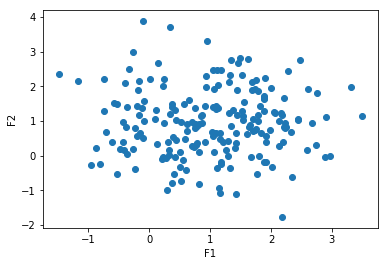

In [13]:
# scatter plot 
plt.scatter(F1,F2)
plt.xlabel('F1')
plt.ylabel('F2')

In [14]:
# Create a dictionary and add all the models that you want to use to detect the outliers
classifiers = {
     'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination = outlier_fraction)
     , 'K-Nearest Neighbors (KNN)' :  KNN(contamination = outlier_fraction)
}

No of Errors :  Angle-based Outlier Detector (ABOD) 34
No of Errors :  K-Nearest Neighbors (KNN) 35


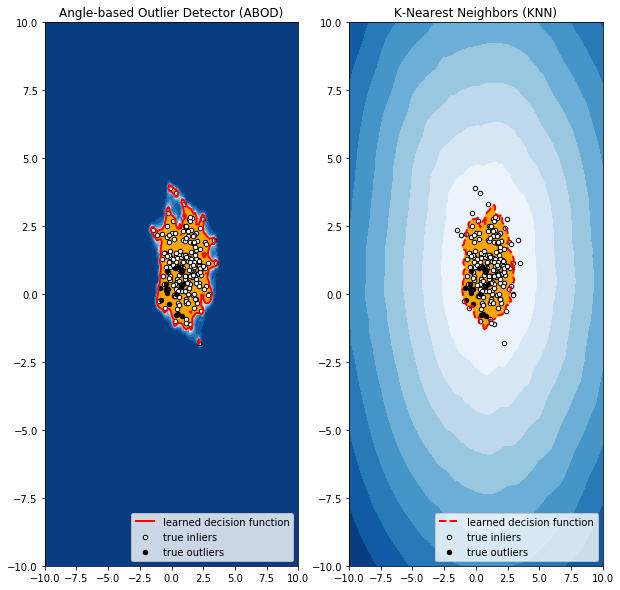

In [16]:
# Fit the data to each model in the dictionary
# See how each model is detecting outliers

#set the figure size
plt.figure(figsize=(10, 10))

# Enumerate() method adds a counter to an iterable and returns it in a form of enumerate object. 
## This enumerate object can then be used directly in for loops 
### or be converted into a list of tuples using list() method.
for i, (clf_name,clf) in enumerate(classifiers.items()): 
    # fit the dataset to the model
    clf.fit(X_train)
    
    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1
    
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)
    
    # no of errors in prediction
    n_errors = (y_pred != y_train).sum()
    print('No of Errors : ',clf_name, n_errors)
    
    # -----------------------------------------------
    # rest of the code is to create the visualization
    # -----------------------------------------------

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outlier_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
    b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
    c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')

    subplot.set_title(clf_name)
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show() 